### 세팅

#### 기본 함수

In [12]:
class model_eval:
    def __init__(self, model=None, X_train=None, y_train=None, X_test=None, y_test=None):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    # 모델 학습
    def model_train(self, cv=None):
        from sklearn.linear_model import LassoCV, LinearRegression, LogisticRegressionCV, Ridge
        from sklearn.svm import SVC, SVR, NuSVC, NuSVR
        from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, ExtraTreeClassifier, ExtraTreeRegressor
        from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
        from xgboost import XGBClassifier, XGBRegressor
        from lightgbm import LGBMClassifier, LGBMRegressor, DaskLGBMRegressor, DaskLGBMClassifier
        from sklearn.metrics import make_scorer,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
        from sklearn.model_selection import cross_validate, GridSearchCV, ParameterGrid
        import pandas as pd
        print('X_train.shape :', self.X_train.shape)
        print('y_train.shape :', self.y_train.shape)
        print('X_test.shape :', self.X_test.shape)
        print('y_test.shape :', self.y_test.shape)
        self.model.fit(self.X_train, self.y_train)
        self.pred = self.model.predict(self.X_test)
        self.cm = confusion_matrix(self.y_test, self.pred)
        print('모델 이름:', self.model.__class__.__name__)
        # params_dict = self.model.get_params()  # 딕셔너리 형태의 파라미터 가져오기
        # params_df = pd.DataFrame(list(params_dict.items()), columns=['파라미터', '값'])
        # self.display_scores(params_df, mean=None)
        print('train_Accuracy_score(훈련정확도) :', accuracy_score(self.y_train, self.model.predict(self.X_train)))
        if isinstance(self.model, GridSearchCV):
            self.model.fit(self.X_train, self.y_train)
            print(self.model.best_score_)
            print(self.model.best_params_)
            return self.model
        else:
            if hasattr(self.model, 'predict_proba'):
                self.pred_proba = self.model.predict_proba(self.X_test)[:,1]
                self.model_test(cv)
            else:
                self.pred_proba = None
                self.model_test(cv)
        return self.model


    def print_scores(self, y_test, pred, pred_proba=None):
        from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
        cm = confusion_matrix(y_test, pred)
        TN, FP, FN, TP = cm.ravel()
        print('오차행렬 \n', cm)
        print('Accuracy_score(정확도) :', accuracy_score(y_test, pred))
        print('Precision(정밀도) : ', precision_score(y_test, pred))
        print('Recall(재현율) :', recall_score(y_test, pred))
        print('TNR(0을 맞춘 비율) :', TN/(TN+FP))
        print('F1 score :', f1_score(y_test, pred))
        if pred_proba is not None:
            print('Roc Auc score :', roc_auc_score(y_test, pred_proba))

    def model_test(self, cv=None):
        import pandas as pd
        from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
        from sklearn.model_selection import cross_validate

        if cv is not None:
            self.cross_validation(cv)
        else:
            self.pred = self.model.predict(self.X_test)
            if hasattr(self.model, 'predict_proba'):
                self.pred_proba = self.model.predict_proba(self.X_test)[:,1]
            else:
                self.pred_proba = None
            self.print_scores(self.y_test, self.pred, self.pred_proba)

    def cross_validation(self, cv):
        from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
        from sklearn.model_selection import cross_validate
        import pandas as pd
        def TNR(y_true, y_pred):
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            return tn / (tn + fp)

        scoring = {
            'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score, average=cv),
            'recall': make_scorer(recall_score, average=cv),
            'f1': make_scorer(f1_score, average=cv),
            'TNR': make_scorer(TNR)
        }

        if hasattr(self.model, 'predict_proba'):
            scoring['roc_auc'] = make_scorer(roc_auc_score, needs_proba=True)

        scores = cross_validate(self.model, self.X_train, self.y_train, cv=5, scoring=scoring)
        scores_df = pd.DataFrame(scores).round(3)
        scores_df.rename(columns={
            'test_accuracy':'Accuracy',
            'test_precision':'Percision',
            'test_recall':'Recall',
            'test_f1':'F1',
            'test_TNR':'TNR',
            'test_roc_auc':'RocAuc'}, inplace=True)
        self.display_scores(scores_df, mean=True)

    def display_scores(self, df, mean=None):
        import pandas as pd
        def is_ipython():
            try:
                __IPYTHON__
                return True
            except NameError:
                return False

        if is_ipython():
            from IPython.display import display
            display(df)
            if mean is not None:
                print()
                display(df.mean())
        else:
            print(df)
            if mean is not None:
                print()
                print(df.mean())


    def model_visual(self, cm_heatmap='b', roc_auc=True):
        import matplotlib.pyplot as plt
        import seaborn as sns
        import matplotlib as mpl
        from sklearn.metrics import roc_curve, auc

        if cm_heatmap is not None:
            if cm_heatmap=='b':
                new_confusion = [[self.cm[1,1], self.cm[1,0]], [self.cm[0,1], self.cm[0,0]]]

                plt.figure(figsize=(5,5))
                sns.heatmap(new_confusion, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = sns.diverging_palette(220, 10, as_cmap = True),
                    xticklabels=['1', '0'], yticklabels=['1', '0']);

                plt.ylabel('Acutral label')
                plt.xlabel('Predicted label')

                title = 'Confusion Matrix'
                plt.title(title, size = 15);
                plt.show()

            elif cm_heatmap=='c':
                new_confusion = [[self.cm[1,1], self.cm[0,0]], [self.cm[1,0], self.cm[0,1]]]

                plt.figure(figsize=(5,5))
                sns.heatmap(new_confusion, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = sns.diverging_palette(220, 10, as_cmap = True),
                    xticklabels=['1', '0'], yticklabels=['Correct', 'Incorrect']);

                plt.ylabel('Correct')
                plt.xlabel('Predicted')

                title = 'Confusion Matrix'
                plt.title(title, size = 15);
                plt.show()


        if roc_auc == True:
            fpr, tpr, thr = roc_curve(self.y_test, self.pred_proba)
            roc_auc = auc(fpr, tpr)

            plt.figure()
            lw = 2  # 라인의 두께 # mediumslateblue indigo
            plt.plot(fpr, tpr, color='red', lw=1, label='ROC curve')
            # plt.fill_between(fpr, tpr, color='mediumslateblue', alpha=0.4)  # hatch와 edgecolor 파라미터 수정
            plt.text(0.8, 0.2, 'AUC = %0.2f' % roc_auc, fontsize=12)  # AUC 값을 표시하는 부분
            # plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # 무작위 선택에 대한 ROC Curve를 그림
            plt.xlim([0.0, 1.0])  # X축의 범위를 설정
            plt.ylim([0.0, 1.05])  # Y축의 범위를 설정
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.show()
        else:
            pass

    def model_save(self):
        model = self.model
        save_type = input('save type : ')
        if save_type == 'pickle':
            import pickle
            save_path = input('save path+name.pickle: ')
            protocol = input('protocol (default pickle.HIGHEST_PROTOCOL, press enter to use default) : ')
            if protocol == '':
                print('디폴트')
                protocol = pickle.HIGHEST_PROTOCOL
            else:
                print('입력')
                protocol = int(protocol)
            with open(save_path, 'wb') as handle:
                pickle.dump(model, handle, protocol=protocol)
        elif save_type == 'joblib':
            import joblib
            save_path = input('save path+name.joblib :')
            joblib.dump(model, save_path)
        return print(f'{model}을 {save_path}에 저장했습니다.')

    def model_load(self):
        type = input('load type :')
        if type == 'pickle':
            import pickle
            load_path = input('load path+name.pickle :')
            with open(load_path, 'rb') as handle:
                self.model = pickle.load(handle)
        elif type == 'joblib':
            import joblib
            load_path = input('load path+name.joblib :')
            self.model = joblib.load(load_path)
        return self.model, print(f'{self.model}을 {load_path}에서 불러왔습니다.')

    def transformer_save(self, transformer):
        save_type = input('save type :')
        if save_type == 'pickle':
            import pickle
            save_path = input('save path+name.pickle:')
            protocol = input('protocol (default pickle.HIGHEST_PROTOCOL, press enter to use default) : ')
            if protocol == '':
                protocol = pickle.HIGHEST_PROTOCOL
            else:
                protocol = int(protocol)
            with open(save_path, 'wb') as handle:
                pickle.dump(transformer, handle, protocol=protocol)
        elif save_type == 'joblib':
            import joblib
            save_path = input('save path+name.joblib :')
            joblib.dump(transformer, save_path)
        return print(f'{transformer}을 {save_path}에 저장했습니다.')

    def transformer_load(self, transformer):
        type = input('load type :')
        if type == 'pickle':
            import pickle
            load_path = input('load path+name.pickle :')
            with open(load_path, 'rb') as handle:
                trans = pickle.load(handle)
        elif type == 'joblib':
            import joblib
            load_path = input('load path+name.joblib :')
            transformer = joblib.load(load_path)
        return transformer, print(f'{transformer}을 {load_path}에서 불러왔습니다.')

#### 필요한 라이브러리

In [13]:
# 기본
import pandas as pd
import numpy as np

# 모델
import sklearn.svm as SVC

# 시각화
import matplotlib as plt
import seaborn as sns

#### 파일 로드

In [14]:
!pip install datasets==1.17.0

#### 데이터셋 로드

In [15]:
from datasets import load_dataset
dataset = load_dataset('smilegate-ai/kor_unsmile')

  0%|          | 0/2 [00:00<?, ?it/s]

#### 형태소 분석기


In [16]:
!apt-get install g++ openjdk-8-jdk
!pip install JPype1
!pip install rhinoMorph

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
g++ is already the newest version (4:11.2.0-1ubuntu1).
openjdk-8-jdk is already the newest version (8u382-ga-1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


클론

In [17]:
!git clone https://github.com/mmopg42/vcvb/
%cd vcvb/data

Cloning into 'vcvb'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 21 (delta 4), reused 21 (delta 4), pack-reused 0
Receiving objects: 100% (21/21), 6.09 MiB | 11.53 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/vcvb/data/vcvb/data/vcvb/data


### 1차 데이터 전처리

In [ ]:
train = pd.DataFrame(dataset['train'])
test = pd.DataFrame(dataset['valid'])

클린을 기준으로 클린이 1이면 혐오 표현이 없는 데이터, 클린이 0 이면 혐오표현이 있는 데이터.

혐오 표현이 있는 것을 찾을 것이므로 clean이 1인 것을 0으로, 0인 것을 1로 해서 target을 설정

In [ ]:
train['target']=train['clean'].replace((1, 0), ( 0, 1))
test['target'] = test['clean'].replace((1, 0), ( 0, 1))
train['문장'].head(20)

0                                일안하는 시간은 쉬고싶어서 그런게 아닐까
1     아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. ...
2     루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o  doin 진짜 띵...
3     홍팍에도 어버이연합인가 보내요 뭐 이런뎃글 있는데 이거 어버이연합측에 신고하면 그쪽...
4     아놔 왜 여기 댓들은 다 여자들이 김치녀라고 먼저 불렸다! 여자들은 더 심하게 그런...
5     고향가서 피방가면 동네 부럴 친구들이랑은 뭐 거르는 거 없이 이야기하니까 막 말하게...
6     예수 십새끼 개새끼 창녀아들 애비실종 가정교육 못받은 무뇌충 허언증 정신병자 사기꾼...
7                          나이쳐먹고 피시방가는 놈들은 대가리에 똥만찬 놈들임
8     출산청같은 소리하네. 우리나라 계집들 다 의무적으로 군대보내면 해결될 일이다. 정신...
9                            재능 ㅂㅅㅌㅊ노 ㅋㅋㅋㅋㅋ나도 합성배우고싶다이기
10                                      가짜 남자는 어떻게 생겼냐?
11                                               이슬람뺨치내
12    아 어린이집에 월요일에 데려다주고 금요일에 데리고 왔단다...... 아 가슴이 너무...
13       갓슬람 정희구현 테러 ㅅㅅㅅㅅ미제양키새끼들에게는 테러가 답이다좆같은 양키 씨발새끼들
14                                      AICPA 따고 넘어갔나보네
15    원 리더십, 원 메시지로 내부 결속을 더 강화하고 외부로 리마커블(remarkabl...
16                                          협박스킬은 패시브랑께
17    위로와 격려를 호텔에서 해? 왜? 저여자도 정상은 아니구만 완전 지네 할아버

In [ ]:
X_train = train['문장']
y_train = train['target']

X_test = test['문장']
y_test = test['target']

In [ ]:
print(y_train.value_counts())
print(y_test.value_counts())

1    11266
0     3739
Name: target, dtype: int64
1    2802
0     935
Name: target, dtype: int64


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect_morp = CountVectorizer(max_features=10000, token_pattern=r"\b\w+\b").fit(X_train)
X_train_final = vect_morp.transform(X_train)
X_test_final = vect_morp.transform(X_test)
print('X_train:\n', repr(X_train_final))
print('X_test:\n', repr(X_test_final))

X_train:
 <15005x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 70670 stored elements in Compressed Sparse Row format>
X_test:
 <3737x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 15016 stored elements in Compressed Sparse Row format>


#### 1차 모델

In [ ]:
X_train_final_float = X_train_final.astype('float32')
X_test_final_float = X_test_final.astype('float32')
from lightgbm import LGBMClassifier
eval = model_eval(LGBMClassifier(n_estimators=1000, boost_from_average=False, learning_rate=0.001), X_train_final_float, y_train, X_test_final_float, y_test)
print(X_train_final_float.shape)
eval.model_train()
eval.model_visual('b')


#### 1차 모델 피드백

예측 결과, 모델이 전부 다 예측을 1로 찍어버리는 결과가 나왔다.

그래서 재현율은 굉장히 높게 나오지만 TNR은 낮게 나오는 문제가 발생.

해당 문제를 형태소 분석을 안해서 일 수도 있다는 생각에 형태소 분석기를 사용해 보았다.

### 2차 모델 전처리

#### 형태소 분석

In [ ]:
import rhinoMorph

rn = rhinoMorph.startRhino()
train_morphed_data_each=[]
test_morphed_data_each=[]
data_all = [train, test]
for idx, val in enumerate(data_all):
  for sentence in val['문장']:
    if idx == 0:
      train_morphed_data_each.append(rhinoMorph.onlyMorph_list(rn, sentence, pos=['NNG', 'NNP', 'VV', 'VA', 'XR', 'IC', 'MM', 'MAG', 'MAJ'], eomi=True))
      train_X_join = [" ".join(sentence) for sentence in train_morphed_data_each]
    elif idx==1:
      test_morphed_data_each.append(rhinoMorph.onlyMorph_list(rn, sentence, pos=['NNG', 'NNP', 'VV', 'VA', 'XR', 'IC', 'MM', 'MAG', 'MAJ'], eomi=True))
      test_X_join = [" ".join(sentence) for sentence in test_morphed_data_each]

print(train_morphed_data_each[:2])
print(test_morphed_data_each[:2])
print(train_X_join[:2])
print(test_X_join[:2])

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect_morp = CountVectorizer(max_features=10000).fit(train_X_join)
X_train_final = vect_morp.transform(train_X_join)
X_test_final = vect_morp.transform(test_X_join)

#### 형태소 분석 후 2차 모델

In [ ]:
X_train_final_float = X_train_final.astype('float32')
X_test_final_float = X_test_final.astype('float32')
from lightgbm import LGBMClassifier
eval = model_eval(LGBMClassifier(n_estimators=1000, boost_from_average=False, learning_rate=0.001), X_train_final_float, y_train, X_test_final_float, y_test)
print(X_train_final_float.shape)
eval.model_train()
eval.model_visual('b')

NameError: ignored

#### 2차 모델 피드백

형태소 분석기를 사용하여 정확도롤 소폭 높였으나 여전히 한 쪽으로 쏠린 결과가 나왔다. 이를 해결하기 위해 데이터 탐색에 들어갔다.

데이터 탐색 결과 2가지 사실을 알 수 있었다.

첫 번째는 해당 데이터가 인터넷 방송에서의 채팅에는 부적절한 단어들이 있음에도 많은 데이터들이 clean에 속해 있다는 것이다.

이를 수정할 필요가 있었다.





예시

- 여시에서 메갈 띵문 보고 메갈 입성- 망하는거 보고 분노에 가득차서 워마드 들어왔노 껄레껄레

- 나련은 지금 페미사이클 끼고 굴러다니는 중이노 ^느^ 뽀송하니 노무딱 좋다 익이야!

- 조선민주주의 인민공화국 창건일에 즈음하여각하와 그리고 조선민주주의 인민공화국 정부와 인민에게 저의 열렬한 축하를 드리게 됨을 커다란 기쁨으로 생각합니다""각하게 저의 가장 숭고한 경의를 표합니다"ㅡ반기문ㅡ


두 번째는 clean한 글과 clean 하지 않은 글 간의 데이터 불균형이 심하다는 것이었다.

이를 아래의 코드로 확인 할 수 있었다.

In [ ]:
print(y_test.value_counts())
print(y_train.value_counts())

1    2802
0     935
Name: target, dtype: int64
1    11266
0     3739
Name: target, dtype: int64


### 3차 데이터 전처리

In [ ]:
!git clone https://github.com/mmopg42/vcvb/
%cd vcvb/data

Cloning into 'vcvb'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 21 (delta 4), reused 21 (delta 4), pack-reused 0
Receiving objects: 100% (21/21), 6.09 MiB | 16.38 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/vcvb/data/vcvb/data/vcvb/data


먼저 의도와 맞지 않은 데이터들을 수정한다.

In [ ]:
import pandas as pd

In [18]:
train=pd.read_csv('/content/vcvb/data/스마게 언스마일 train.CSV', encoding='cp949')
test=pd.read_csv('/content/vcvb/data/스마게 언스마일 test.CSV', encoding='cp949')

In [ ]:
display(train.head())

,문장,여성/가족,남성,성소수자,인종/국적,연령,지역,종교,기타 혐오,악플/욕설,clean,개인지칭
0,일안하는 시간은 쉬고싶어서 그런게 아닐까,0,0,0,0,0,0,0,0,0,1,0
1,아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. ...,0,0,0,0,0,0,1,0,0,0,0
2,루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o doin 진짜 띵...,0,0,0,0,0,0,0,0,0,1,0
3,홍팍에도 어버이연합인가 보내요 뭐 이런뎃글 있는데 이거 어버이연합측에 신고하면 그쪽...,0,0,0,0,0,0,0,0,0,1,0
4,아놔 왜 여기 댓들은 다 여자들이 김치녀라고 먼저 불렸다! 여자들은 더 심하게 그런...,1,0,0,0,0,0,0,0,0,0,0


In [19]:
train['target']=train['clean'].replace((1, 0), ( 0, 1))
test['target'] = test['clean'].replace((1, 0), ( 0, 1))

In [ ]:
display(train['target'].value_counts())
display(test['target'].value_counts())

1    11334
0     3668
Name: target, dtype: int64

1    2809
0     928
Name: target, dtype: int64

In [20]:
X_train = train['문장']
y_train = train['target']
X_test = test['문장']
y_test = test['target']

형태소 분석 및 카운트벡터

In [ ]:
import rhinoMorph

rn = rhinoMorph.startRhino()
train_morphed_data_each=[]
test_morphed_data_each=[]
data_all = [X_train, X_test]
for idx, val in enumerate(data_all):
  for sentence in val:
    if idx == 0:
      train_morphed_data_each.append(rhinoMorph.onlyMorph_list(rn, sentence, pos=['NNG', 'NNP', 'VV', 'VA', 'XR', 'IC', 'MM', 'MAG', 'MAJ'], eomi=True))
      train_X_join = [" ".join(sentence) for sentence in train_morphed_data_each]
    elif idx==1:
      test_morphed_data_each.append(rhinoMorph.onlyMorph_list(rn, sentence, pos=['NNG', 'NNP', 'VV', 'VA', 'XR', 'IC', 'MM', 'MAG', 'MAJ'], eomi=True))
      test_X_join = [" ".join(sentence) for sentence in test_morphed_data_each]


from sklearn.feature_extraction.text import CountVectorizer
vect_morp = CountVectorizer(max_features=10000).fit(train_X_join)
X_train_final = vect_morp.transform(train_X_join)
X_test_final = vect_morp.transform(test_X_join)

filepath:  /usr/local/lib/python3.10/dist-packages
classpath:  /usr/local/lib/python3.10/dist-packages/rhinoMorph/lib/rhino.jar
RHINO started!


#### 3차 모델

여전히 불균형은 심하지만 일단 모델에 있는 매개변수인 class_weight를 사용해서 해결해보기로 한다

light gbm

In [ ]:
X_train_final_float = X_train_final.astype('float32')
X_test_final_float = X_test_final.astype('float32')
from lightgbm import LGBMClassifier
eval = model_eval(LGBMClassifier(n_estimators=1000, learning_rate=0.0001, class_weight='balanced'), X_train_final_float, y_train, X_test_final_float, y_test)
print(X_train_final_float.shape)
eval.model_train()
eval.model_visual('b')

NameError: ignored

로지스틱

In [ ]:
from sklearn.linear_model import LGBMCRegressionCV

e = model_eval(LogisticRegressionCV(solver='liblinear', max_iter=10000, class_weight='balanced'), X_train_final, y_train, X_test_final, y_test)
e.model_train()
e.model_visual()

svc

In [ ]:
from sklearn.svm import SVC
e = model_eval(SVC(C=7000, gamma='auto', kernel='rbf', class_weight='balanced'), X_train_final, y_train, X_test_final, y_test)
e.model_train()
e.model_visual()

#### 3차 모델 피드백

어느 정도 클래스의 불균형이 해소되었지만 정확도가 부족하다고 판단이 되어, target이 0인 데이터를 추가하여 불균형을 해소하기로 결정하였다.

### 4차 데이터 전처리

https://github.com/kocohub/korean-hate-speech

해당 데이터를 선정.

해당 데이터는 확인 결과 전부 클린 한 데이터로 판단 되어 데이터 추가에 적합하다고 생각되었다.


In [21]:
import os

with open('/content/vcvb/data/깨끗한대화35000개.txt', 'r', encoding='cp949') as file:
    lines = file.readlines()
    lines = [line.strip() for line in lines]

add_data = pd.DataFrame(lines)
add_data['target'] = 0
add_data.rename(columns={0:'문장'}, inplace=True)
add_data

,문장,target
0,"""프로관심러 안녕? 새해 복 많이 받아!! 새해 첫날인데 뭐하면서 시간 보내고 있니?",0
1,난 집콕하면서 개인라디오방송했어,0
2,요즘 새로 생긴 취미거든~ㅎㅎ,0
3,어머니가 볼링 치는 거 좋아하셔? 오와 어머니 운동 좋아하시는구나~~,0
4,오늘은 어떤 하루를 보내고 있니?,0
...,...,...
35674,가격이 역시 꽤 나가네,0
35675,제이드 너랑 대화하는거 신난다 우리 내일 또 만날 수 있을까?,0
35676,그래 ^^,0
35677,난 이만 잘준비 해야겠어,0


부족한 데이터 수 만큼 추가

In [22]:
X_train = pd.concat([X_train, add_data['문장'].head(11334-3668)])
y_train = pd.concat([y_train, add_data['target'].head(11334-3668)])

X_test = pd.concat([X_test, add_data['문장'].tail(2809-928)])
y_test = pd.concat([y_test, add_data['target'].tail(2809-928)])

개수 확인

In [ ]:
display(y_train.value_counts())
display(y_test.value_counts())

0    11334
1    11334
Name: target, dtype: int64

1    2809
0    2809
Name: target, dtype: int64

형태소 분석 및 카운트 벡터

In [23]:
import rhinoMorph

rn = rhinoMorph.startRhino()
train_morphed_data_each=[]
test_morphed_data_each=[]
data_all = [X_train, X_test]
for idx, val in enumerate(data_all):
  for sentence in val:
    if idx == 0:
      train_morphed_data_each.append(rhinoMorph.onlyMorph_list(rn, sentence, pos=['NNG', 'NNP', 'VV', 'VA', 'XR', 'IC', 'MM', 'MAG', 'MAJ'], eomi=True))
      train_X_join = [" ".join(sentence) for sentence in train_morphed_data_each]
    elif idx==1:
      test_morphed_data_each.append(rhinoMorph.onlyMorph_list(rn, sentence, pos=['NNG', 'NNP', 'VV', 'VA', 'XR', 'IC', 'MM', 'MAG', 'MAJ'], eomi=True))
      test_X_join = [" ".join(sentence) for sentence in test_morphed_data_each]


from sklearn.feature_extraction.text import CountVectorizer
vect_morp = CountVectorizer(max_features=10000).fit(train_X_join)
X_train_final = vect_morp.transform(train_X_join)
X_test_final = vect_morp.transform(test_X_join)

filepath:  /usr/local/lib/python3.10/dist-packages
classpath:  /usr/local/lib/python3.10/dist-packages/rhinoMorph/lib/rhino.jar
JVM is already started~
RHINO started!


lightgbm

(22668, 10000)
X_train.shape : (22668, 10000)
y_train.shape : (22668,)
X_test.shape : (5618, 10000)
y_test.shape : (5618,)
모델 이름: LGBMClassifier
train_Accuracy_score(훈련정확도) : 0.7633668607728957
오차행렬 
 [[2361  448]
 [ 906 1903]]
Accuracy_score(정확도) : 0.7589889640441438
Precision(정밀도) :  0.8094427903019992
Recall(재현율) : 0.6774652901388395
TNR(0을 맞춘 비율) : 0.8405126379494482
F1 score : 0.7375968992248063
Roc Auc score : 0.8364735939418649


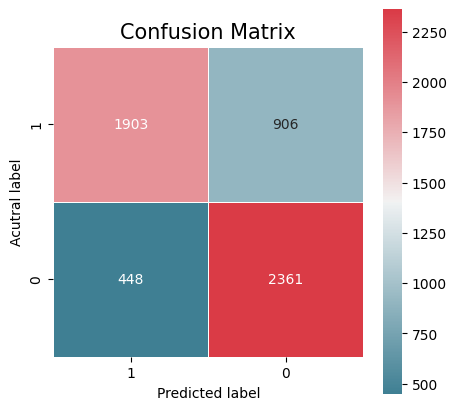

In [ ]:
X_train_final_float = X_train_final.astype('float32')
X_test_final_float = X_test_final.astype('float32')
from lightgbm import LGBMClassifier
eval = model_eval(LGBMClassifier(n_estimators=10000, learning_rate=0.0001), X_train_final_float, y_train, X_test_final_float, y_test)
print(X_train_final_float.shape)
eval.model_train()
eval.model_visual()

svm

X_train.shape : (22668, 10000)
y_train.shape : (22668,)
X_test.shape : (5618, 10000)
y_test.shape : (5618,)
모델 이름: SVC
train_Accuracy_score(훈련정확도) : 0.9531056996647256
오차행렬 
 [[2486  323]
 [ 498 2311]]
Accuracy_score(정확도) : 0.8538625845496618
Precision(정밀도) :  0.8773728170083523
Recall(재현율) : 0.8227127091491634
TNR(0을 맞춘 비율) : 0.8850124599501602
F1 score : 0.8491640639353297
Roc Auc score : 0.9170594923173885


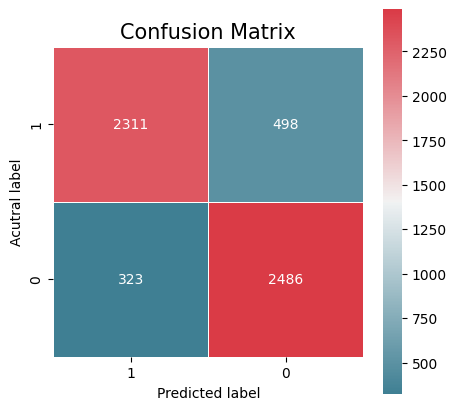

In [ ]:
from sklearn.svm import SVC
e = model_eval(SVC(C=7300, gamma='auto', kernel='rbf',probability=True), X_train_final, y_train, X_test_final, y_test)
e.model_train()
e.model_visual()

로지스틱 회귀

X_train.shape : (22668, 10000)
y_train.shape : (22668,)
X_test.shape : (5618, 10000)
y_test.shape : (5618,)
모델 이름: LogisticRegressionCV
train_Accuracy_score(훈련정확도) : 0.9479442385742015
오차행렬 
 [[2486  323]
 [ 469 2340]]
Accuracy_score(정확도) : 0.8590245639017444
Precision(정밀도) :  0.8787082238077356
Recall(재현율) : 0.8330366678533286
TNR(0을 맞춘 비율) : 0.8850124599501602
F1 score : 0.8552631578947368
Roc Auc score : 0.9253674142298803


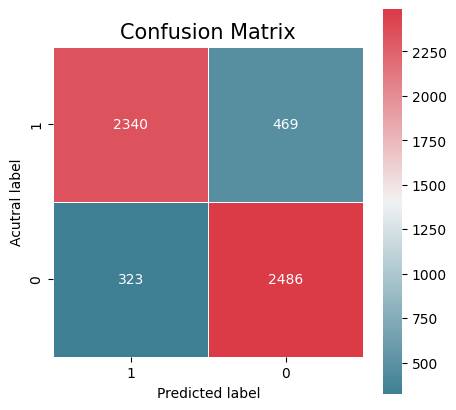

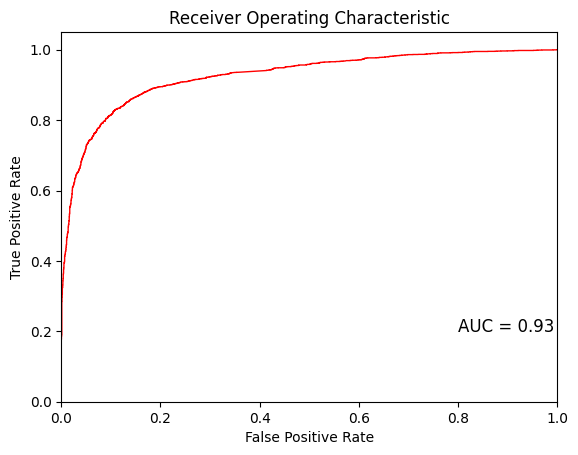

In [23]:
from sklearn.linear_model import LogisticRegressionCV

e = model_eval(LogisticRegressionCV(solver='liblinear', max_iter=10000), X_train_final, y_train, X_test_final, y_test)
e.model_train()
e.model_visual()

X_train.shape : (22668, 10000)
y_train.shape : (22668,)
X_test.shape : (5618, 10000)
y_test.shape : (5618,)
모델 이름: LogisticRegressionCV
train_Accuracy_score(훈련정확도) : 0.9479442385742015
오차행렬 
 [[2488  321]
 [ 468 2341]]
Accuracy_score(정확도) : 0.859558561765753
Precision(정밀도) :  0.8794139744552968
Recall(재현율) : 0.8333926664293343
TNR(0을 맞춘 비율) : 0.8857244571021716
F1 score : 0.8557850484372144
Roc Auc score : 0.9253693152546719


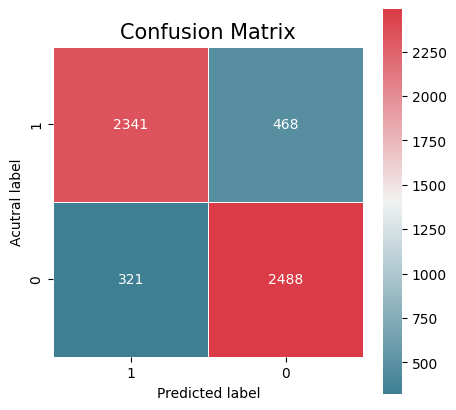

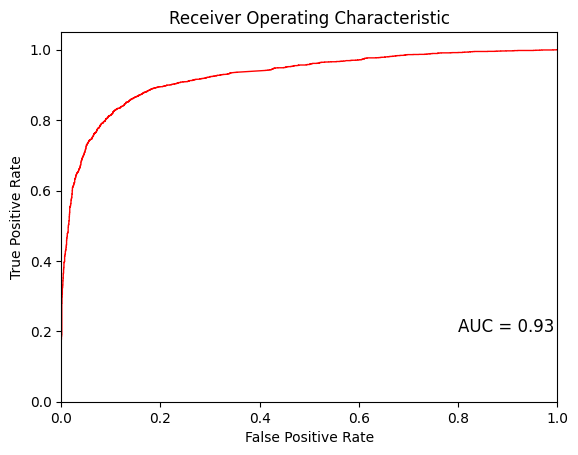

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

e = model_eval(LogisticRegressionCV(solver='newton-cholesky', max_iter=10000), X_train_final, y_train, X_test_final, y_test)
e.model_train()
e.model_visual()

In [ ]:
import matplotlib as mpl
mpl.style.use('ggplot')
sns.set_style('white')

### 시각화

#### 폰트 다운

In [ ]:
!rm ~/.cache/matplotlib -rf
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121445 files and direc

### 그래프 그리기

In [ ]:
import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=path)

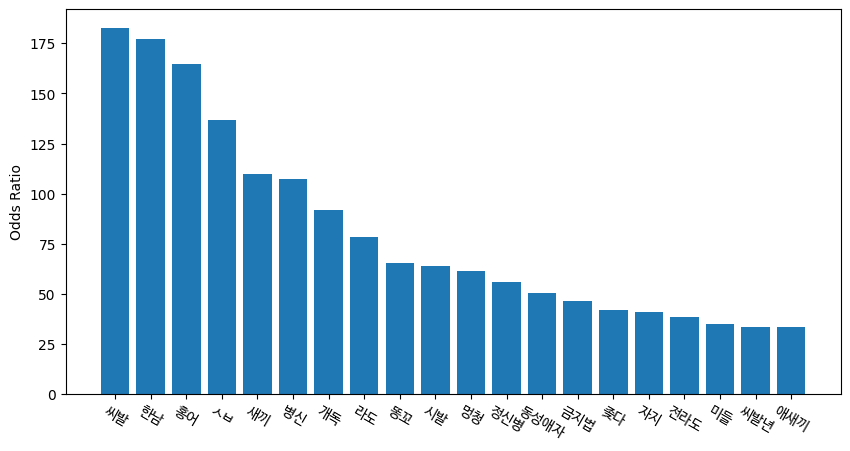

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

# 데이터 로드
# data = load_breast_cancer()
# X = data.data
# y = data.target

# 로지스틱 회귀 모델 학습
# model = LogisticRegression(max_iter=5000)
# model.fit(X, y)

# 오즈 비 계산
odds_ratio = np.exp(e.model.coef_)

# # 오즈 비 시각화
# plt.figure(figsize=(10,5))
# plt.bar(vect_morp.get_feature_names_out(), odds_ratio[0])

# 오즈 비와 해당하는 특성 이름을 함께 저장
odds_ratio_with_names = list(zip(vect_morp.get_feature_names_out(), odds_ratio[0]))

# 오즈 비를 기준으로 정렬
sorted_odds_ratio_with_names = sorted(odds_ratio_with_names, key=lambda x: x[1], reverse=True)

# 상위 20개만 선택
top_20_odds_ratio_with_names = sorted_odds_ratio_with_names[:20]

# 상위 20개의 오즈 비와 특성 이름 분리
top_20_names, top_20_odds_ratio = zip(*top_20_odds_ratio_with_names)

# 오즈 비 시각화
plt.figure(figsize=(10,5))
plt.bar(top_20_names, top_20_odds_ratio)
plt.xticks(rotation=330, fontproperties=fontprop)
plt.ylabel('Odds Ratio')
plt.show()



로지스틱 회귀로 최종 모델 선정

### 모델 테스트 세팅

최상단의 세팅을 실행 했을 경우 실행

In [ ]:
def model_load():
    import pickle
    load_path = '/content/vcvb/data/logistic_model.pickle'
    with open(load_path, 'rb') as handle:
        model = pickle.load(handle)
    return model

def transformer_load():
    import pickle
    load_path = '/content/vcvb/data/vect.pickle'
    with open(load_path, 'rb') as handle:
        trans = pickle.load(handle)
    return trans

model = model_load()
trans = transformer_load()

def model_test(test_data):
    import rhinoMorph
    from sklearn.linear_model import LogisticRegressionCV
    rn = rhinoMorph.startRhino()
    test_data_join = []
    test_data_morp = []
    test_data_morp.append(rhinoMorph.onlyMorph_list(rn, test_data, pos=['NNG', 'NNP', 'VV', 'VA', 'XR', 'IC', 'MM', 'MAG', 'MAJ'], eomi=True))
    test_data_join = [" ".join(test_data) for test_data in test_data_morp]
    test = trans.transform(test_data_join)
    return model.predict(test)

### 모델 테스트 세팅

세팅을 실행 안 할시 실행

In [9]:
!git clone https://github.com/mmopg42/vcvb/
%cd vcvb/data

!apt-get install g++ openjdk-8-jdk
!pip install JPype1
!pip install rhinoMorph

def model_load():
    import pickle
    load_path = '/content/vcvb/data/logistic_model.pickle'
    with open(load_path, 'rb') as handle:
        model = pickle.load(handle)
    return model

def transformer_load():
    import pickle
    load_path = '/content/vcvb/data/vect.pickle'
    with open(load_path, 'rb') as handle:
        trans = pickle.load(handle)
    return trans

model = model_load()
trans = transformer_load()

def model_test(test_data):
    import rhinoMorph
    from sklearn.linear_model import LogisticRegressionCV
    rn = rhinoMorph.startRhino()
    test_data_join = []
    test_data_morp = []
    test_data_morp.append(rhinoMorph.onlyMorph_list(rn, test_data, pos=['NNG', 'NNP', 'VV', 'VA', 'XR', 'IC', 'MM', 'MAG', 'MAJ'], eomi=True))
    test_data_join = [" ".join(test_data) for test_data in test_data_morp]
    test = trans.transform(test_data_join)
    return model.predict(test)

Cloning into 'vcvb'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 21 (delta 4), reused 21 (delta 4), pack-reused 0
Receiving objects: 100% (21/21), 6.09 MiB | 12.04 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/vcvb/data/vcvb/data
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
g++ is already the newest version (4:11.2.0-1ubuntu1).
openjdk-8-jdk is already the newest version (8u382-ga-1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


### 모델 테스트

In [10]:
from sklearn.linear_model import LogisticRegressionCV
model_test(input('판별할 문장을 넣어주세요:'))

판별할 문장을 넣어주세요:ㅁㄴㅇㅁㄴㅇ
filepath:  /usr/local/lib/python3.10/dist-packages
classpath:  /usr/local/lib/python3.10/dist-packages/rhinoMorph/lib/rhino.jar
JVM is already started~
RHINO started!


AttributeError: ignored

In [ ]:
[['일안', '시간', '쉬다', '그렇다'], ['아동', '성범죄', '폐', '도버', '기록', '끊어지다', '영원히', '고통', '받다', '무슬림', '푸다', '근친', '떨어지다', '출산', '위험', '다']]
[['ㅇ', 'ㄱ', 'ㄹ', 'ㅇ', '진짜', '죽다', '상관없다', '마인드', '싸우다', '지금', '서열', '상', '타다', '취', '식칼', '들다', '나다', '안', '찌르다', '찌르다', '하다', '애비', '충', '내다', '동', '충', '알다', '아서', '기다', '한번', '서열', '잡다', '그', '담', '길다', '때', '더', '세', '확실', '짓누르다', '있다', '익다'], ['여자', '취미', '애', '낳다', '취미', '좀', '가지다']]
['일안 시간 쉬다 그렇다', '아동 성범죄 폐 도버 기록 끊어지다 영원히 고통 받다 무슬림 푸다 근친 떨어지다 출산 위험 다']
['ㅇ ㄱ ㄹ ㅇ 진짜 죽다 상관없다 마인드 싸우다 지금 서열 상 타다 취 식칼 들다 나다 안 찌르다 찌르다 하다 애비 충 내다 동 충 알다 아서 기다 한번 서열 잡다 그 담 길다 때 더 세 확실 짓누르다 있다 익다', '여자 취미 애 낳다 취미 좀 가지다']

In [ ]:
tokens = vect_morp.get_feature_names_out()

X_train_array = X_train_final.toarray()

# 각 열의 합을 계산하여 단어의 빈도를 얻음
frequency = np.sum(X_train_array, axis=0)

# 빈도와 토큰을 매칭하여 딕셔너리 생성
freq_dict = {token: freq for token, freq in zip(tokens, frequency)}

print(freq_dict)

{'5g': 3, 'ai': 13, 'atm': 3, 'cgv': 1, 'c발': 1, 'daum': 1, 'ebs': 1, 'gs25': 2, 'jtbc': 1, 'la': 1, 'lg': 2, 'mb': 4, 'mbc': 1, 'ok': 4, 'pc': 25, 'pc방': 2, 'sbs': 2, 'sk': 1, 'sns': 8, 'tv': 6, 'url': 1, 'ㄱㅅ': 4, 'ㄴㄴ': 19, 'ㄷㄷ': 142, 'ㅂㄷㅂㄷ': 17, 'ㅂㅅ': 21, 'ㅅㅂ': 135, 'ㅇㅇ': 83, 'ㅇㅇㅇ': 6, 'ㅈㅈ': 11, 'ㅉㅉ': 103, 'ㅋㅋ': 9529, 'ㅎㅎ': 1177, 'ㅜㅜ': 141, 'ㅠㅠ': 716, 'ㅡㅡ': 53, '가감': 1, '가거': 3, '가게': 35, '가격': 22, '가계': 1, '가곡': 1, '가공': 1, '가관': 4, '가구': 5, '가까워다': 1, '가까이': 20, '가깝다': 24, '가꾸다': 3, '가끔': 61, '가끔가다가': 2, '가난': 9, '가너': 2, '가늘다': 26, '가늠': 3, '가능': 95, '가능성': 17, '가다': 1133, '가독': 2, '가동': 3, '가두다': 9, '가득': 31, '가뜩이나': 4, '가락': 1, '가락국수': 1, '가랑': 1, '가랑이': 2, '가량': 2, '가로채다': 2, '가루': 3, '가르다': 11, '가르치다': 37, '가르침': 3, '가리': 15, '가리다': 51, '가린': 4, '가만': 9, '가만있다': 5, '가만히': 31, '가면': 3, '가명': 2, '가문': 2, '가물가물': 5, '가뭄': 2, '가방': 8, '가버리다': 2, '가볍다': 12, '가보': 2, '가보다': 52, '가부장': 8, '가사': 15, '가산점': 4, '가상': 3, '가성': 15, '가세': 8, '가소': 2, '가수': 11, '가스': 7, '가스레인지': 1, '가스실': 8

In [ ]:
!pip install wordcloud

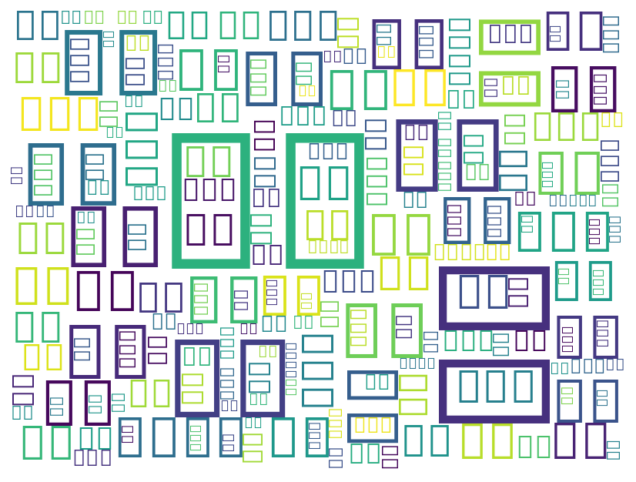

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 워드클라우드 객체 생성
wordcloud = WordCloud(background_color='white', width=800, height=600)

# 워드클라우드 생성
wordcloud = wordcloud.generate_from_frequencies(freq_dict)

# 워드클라우드 시각화
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
coefficients = e.model.coef_[0]
tokens = vect_morp.get_feature_names_out()
# 계수와 토큰을 매칭하여 딕셔너리 생성
coeff_dict = {token: coeff for token, coeff in zip(tokens, coefficients)}

brain_mask = np.array(Image.open("/content/01.22080423.111.png"))

# 워드클라우드 객체 생성
wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
                      background_color='white', width=800, height=600, mask=brain_mask)

# 워드클라우드 생성
wordcloud = wordcloud.generate_from_frequencies(coeff_dict)

# 워드클라우드 시각화
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

NameError: ignored

In [ ]:
dic = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse = True))
print(dic)

{'ㅋㅋ': 9529, '하다': 6056, '되다': 2399, '있다': 2109, '보다': 1679, '없다': 1523, '새끼': 1509, '같다': 1491, 'ㅎㅎ': 1177, '좋다': 1168, '가다': 1133, '진짜': 1025, '알다': 979, '여자': 864, '먹다': 861, '맞다': 830, '사람': 807, '너무': 723, 'ㅠㅠ': 716, '오다': 709, '한남': 629, '많다': 624, '좆다': 599, '좋아하다': 597, '살다': 596, '나오다': 589, '들다': 584, '남자': 583, '쓰다': 582, '받다': 572, '그냥': 513, '존나': 500, '생각': 489, '한국': 471, '모르다': 432, '말다': 427, '무슨': 425, '근데': 420, '많이': 408, '그렇다': 385, '못하다': 380, '전라도': 372, '지금': 370, '씨발': 368, '주다': 360, '병신': 351, '시발': 350, '저런': 348, '나라': 340, '만들다': 337, '마음': 336, '치다': 329, '게이': 323, '다니다': 321, '오늘': 318, '요즘': 316, '이제': 311, '이런': 310, '똥꼬': 307, '내다': 286, '이기다': 286, '동성애': 285, '정말': 284, '파다': 283, '일베': 281, '남다': 270, '자다': 270, '홍어': 269, '듣다': 266, '재미있다': 266, '목사': 264, '개독': 261, '교회': 257, '크다': 250, '맛있다': 249, '안되다': 249, '싫다': 248, '문제': 245, '중국': 238, '정도': 235, '김치': 234, '시간': 233, '틀다': 233, '그런': 229, '보이다': 228, '죽다': 226, '다른': 222, '이야기': 221, '죽

In [ ]:
from wordcloud import WordCloud
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 텍스트 데이터
text = "your text data here"

# 이미지 파일 읽기
mask_image = np.array(Image.open(freq_dict))

# 워드 클라우드 생성
wordcloud = WordCloud(background_color="white", mask=mask_image, contour_width=3, contour_color='black').generate(text)

# 워드 클라우드 시각화
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


AttributeError: ignored

In [19]:

e.model_save()


save type : pickle
save path+name.pickle: model.pickle
protocol (default pickle.HIGHEST_PROTOCOL, press enter to use default) : 4
입력
LogisticRegressionCV(max_iter=10000, solver='liblinear')을 model.pickle에 저장했습니다.
save type :pickle
save path+name.pickle:vect.pickle
protocol (default pickle.HIGHEST_PROTOCOL, press enter to use default) : 4
vect_morp을 vect.pickle에 저장했습니다.


In [18]:
%cd /content/Untitled Folder

/content/Untitled Folder


In [25]:
e.transformer_save(vect_morp)

save type :pickle
save path+name.pickle:vect1.pickle
protocol (default pickle.HIGHEST_PROTOCOL, press enter to use default) : 4
CountVectorizer(max_features=10000)을 vect1.pickle에 저장했습니다.
